<h1>Imports</h1>

In [1]:
import tensorflow as tf
TF_FORCE_GPU_ALLOW_GROWTH= True
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using the CPU instead.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip , RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import Dense , Dropout, BatchNormalization , GlobalAveragePooling2D , Conv2D , MaxPooling2D , Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , AveragePooling2D , Dropout
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ModelModifier
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetV2B0
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear



2024-03-24 08:24:39.389211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 08:24:39.389231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 08:24:39.389814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 08:24:39.393232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 08:24:39.861258: W tensorflow/compiler/tf2

<h1> Load Dataset </h1>

In [2]:

trainining_data_path = 'brain_images/Training/' # Path to folder containing training image data
testing_data = 'brain_images/Testing/' # Path to folder containing testing image data

training_imageGen = IDG(
                rescale=1./255,
                shear_range= 0.2,
                zoom_range = 0.3,
                width_shift_range = 0.2,
                height_shift_range  =0.2,
                fill_mode = "nearest",
                validation_split=0.2)

testing_imageGen = IDG(rescale=1./255)

tf.random.set_seed(123)

BATCH_SIZE = 64 
IMAGE_SIZE = (150, 150)

training_data = training_imageGen.flow_from_directory(
    trainining_data_path,
    shuffle = True,
    seed=123,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')

validation_data = training_imageGen.flow_from_directory(
    trainining_data_path,
    shuffle=True,
    seed=123,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')

class_names = training_data.class_indices

testing_data = testing_imageGen.flow_from_directory(
    testing_data,
    seed=123,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

print(f"Class names: {class_names}")


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


<h1> Visualising Dataset</h1>

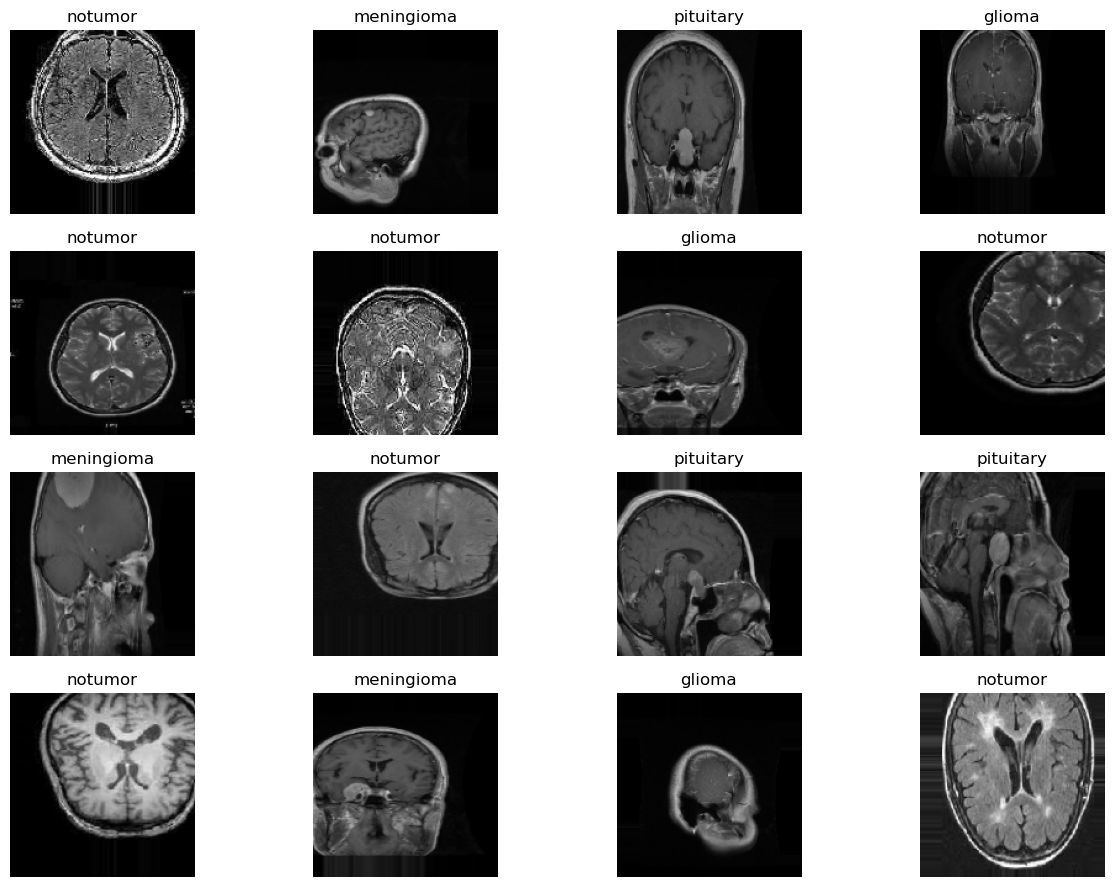

In [3]:
classes = list(class_names.keys())

x,y = next(training_data)                             #function returns the next item in an iterator.
def plotImages(x,y):
    plt.figure(figsize=[15,11])                 #size of the plot
    for i in range(16):                         #16 images
        plt.subplot(4,4,i+1)                    #4 by 4 plot    
        plt.imshow(x[i])                        #Imshow() is a function of matplotlib displays the image
        plt.title(classes[np.argmax(y[i])])     # Class of the image will be it's title
        plt.axis("off")
    plt.show() 

plotImages(x,y)

<h1> Analyze Dataset</h1> 

In [4]:
# How many images for each class in training_dataset
labels = training_data.labels

class_counts = np.bincount(labels)

class_counts_dict = {class_name: class_counts[class_index] for class_name, class_index in class_names.items()}

print(f"Class counts: {class_counts_dict}")

Class counts: {'glioma': 1057, 'meningioma': 1072, 'notumor': 1276, 'pituitary': 1166}


<h1>Modle</h1>

In [5]:
from keras.regularizers import l2

dropout_rate = 0.3

MobileNetV2_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)
EfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = EfficientNetV2B0_model(inputs)
x = Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
x = MaxPooling2D((2 , 2))(x)
x = Dropout(dropout_rate)(x)
x = Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(dropout_rate)(x)
x = Dense(10, activation='relu', kernel_regularizer=l2(0.01))(x)
outputs = Dense(4, activation='softmax')(x)

# model = Sequential([
#     # first Layer
#     Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=IMAGE_SIZE + (3,)),
#     MaxPooling2D((2, 2)),
#     # second layer
#     Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.20),
#     Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=IMAGE_SIZE + (3,)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(10, activation='relu'),
#     Dense(4, activation='softmax')
# ])

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(optimizer='Adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


2024-03-24 08:24:41.780490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 08:24:41.780648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 08:24:41.780750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2, 2, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 16)          4624  

<h1> Evaluation </h1>

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2,
    monitor='val_loss',
    restore_best_weights=True,
    verbose= 1
)

from sklearn.utils import class_weight

labels = training_data.labels
unique_classes = np.unique(labels)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y = labels)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}



history = model.fit(training_data, epochs=10, validation_data=validation_data , batch_size= BATCH_SIZE, verbose=1, class_weight=class_weights_dict)

print("Model evaluation")
model.evaluate(testing_data)

Epoch 1/10


2024-03-24 08:24:52.772372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-24 08:24:54.205647: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-24 08:24:55.361360: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f372cbb20c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 08:24:55.361379: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-24 08:24:55.366109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711268695.431145   85010 device_compiler.h:186] Compile

72/72 [==============================] - 39s 236ms/step - loss: 2.2716 - accuracy: 0.3995 - val_loss: 2.1660 - val_accuracy: 0.3164
Epoch 2/10
72/72 [==============================] - 19s 265ms/step - loss: 1.6929 - accuracy: 0.5922 - val_loss: 1.9598 - val_accuracy: 0.2787
Epoch 3/10
72/72 [==============================] - 19s 263ms/step - loss: 1.3135 - accuracy: 0.6819 - val_loss: 2.0253 - val_accuracy: 0.2358
Epoch 4/10
72/72 [==============================] - 19s 266ms/step - loss: 0.9843 - accuracy: 0.7530 - val_loss: 1.7620 - val_accuracy: 0.3427
Epoch 5/10
72/72 [==============================] - 19s 265ms/step - loss: 0.7625 - accuracy: 0.8416 - val_loss: 1.9120 - val_accuracy: 0.2752
Epoch 6/10
72/72 [==============================] - 19s 269ms/step - loss: 0.5532 - accuracy: 0.9029 - val_loss: 2.0711 - val_accuracy: 0.3146
Epoch 7/10
72/72 [==============================] - 19s 265ms/step - loss: 0.4698 - accuracy: 0.9215 - val_loss: 1.6799 - val_accuracy: 0.2340
Epoch 8/10

[1.5880303382873535, 0.3012967109680176]

<h1> Grad-Cam</h1>

2/2 [==============================] - 1s 9ms/step


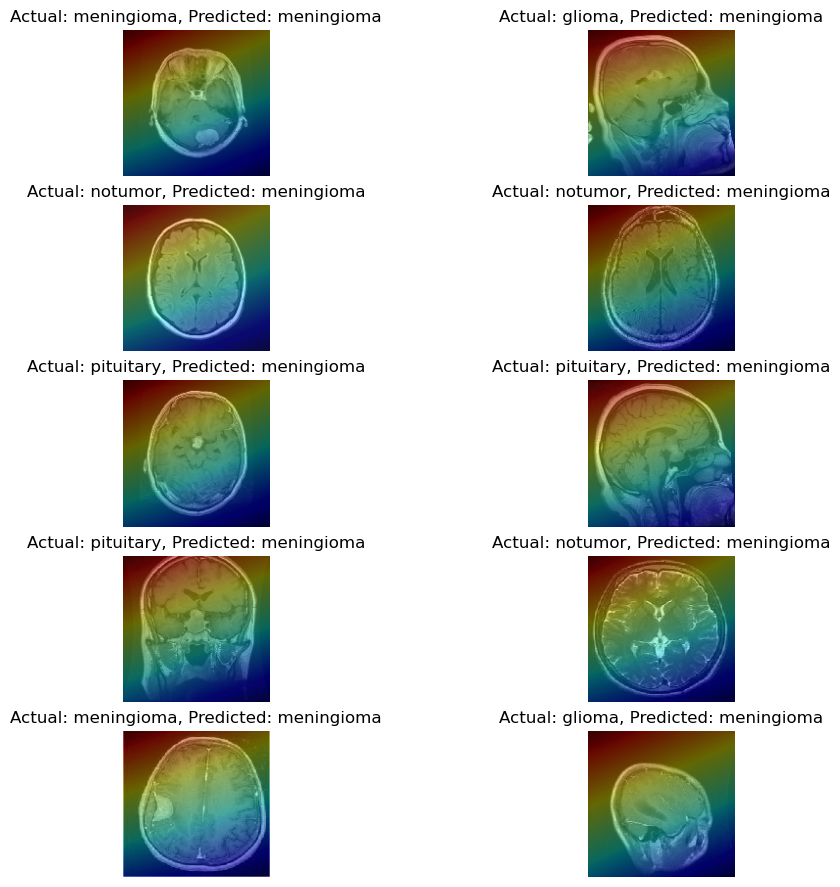

In [7]:
#Get 10 images from the testing dataset

images, labels = next(testing_data)

while len(images) < 10:
    more_images, more_labels = next(testing_data)
    images = np.concatenate([images, more_images])
    labels = np.concatenate([labels, more_labels])

# Get the model's predictions for the images
    
predictions = model.predict(images)

# Get the predicted classes

predicted_classes = np.argmax(predictions, axis=1)

# Get the actual classes

actual_classes = np.argmax(labels, axis=1)

# Get the class names

class_names = list(testing_data.class_indices.keys())

gradcam = Gradcam(model, model_modifier=ReplaceToLinear())

plt.figure(figsize=(11, 11))

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, predicted_classes)):
    if i >= 10:
        break

    # Generate heatmap with Grad-CAM for the predicted class
    loss = CategoricalScore(predicted_class)
    heatmap = gradcam(loss, np.array([image]), penultimate_layer=-1)

    plt.subplot(5, 2, i + 1)
    
    # Display the original image
    plt.imshow(image, alpha=1.0)
    
    # Display the heatmap on top of the original image
    plt.imshow(heatmap[0], cmap='jet', alpha=0.4)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.show()


